# Reviving, reproducing and revisiting Axelrod's second tournament

In [7]:
import pathlib
import re

import axelrod as axl
import axelrod_fortran as axlf
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

assert axl.__version__ == '3.11.0', axl.__version__
assert axlf.__version__ == '0.4.2', axlf.__version__
assert matplotlib.__version__ == '2.1.2', matplotlib.__version__ 
assert np.__version__ == '1.14.0', np.__version__
assert pd.__version__ == '0.20.3', pd.__version__
assert sklearn.__version__ == '0.19.0', sklearn.__version__

%matplotlib inline

# Building the appendices

In [9]:
with open("../assets/list_of_original_tournament_players.tex", "w") as f:
    for name in axlf.second_tournament_strategies:
        dictionary = axlf.characteristics[name]
        f.write("\item {name} - Original rank: {original_rank}. Authored by {author}\n".format(name=name, 
                                                             author=dictionary["author"],
                                                             original_rank=dictionary["original_rank"]))

## Reproducing the original tournament

In [14]:
def get_turns(filename):
    """
    Read the number of turns if included in the file name
    """
    match = re.search("[0-9]+(?=(_turns))", str(filename))
    return int(match.group(0))

def get_repetitions(filename):
    """
    Read the number of turns if included in the file name
    """
    match = re.search("[0-9]+(?=(_repetitions))", str(filename))
    return int(match.group(0))

def read_tournament_repetitions(files, player_names=None):
    """
    Read the scores from a collection of gz files 
    representing repetitions of tournaments.
    """
    number_of_opponents = len(player_names) - 1
    dfs = []
    for gz_path in files:
        dfs.append(pd.read_csv(str(gz_path), header=None).iloc[:,0:number_of_opponents + 1])
        
        turns = get_turns(gz_path)
        
        dfs[-1] /= turns * (number_of_opponents)  # Scale all metrics
        dfs[-1].columns = player_names
        
    df = pd.concat(dfs, ignore_index=True)
    return df

In [15]:
original_tournament_data_path = pathlib.Path("./data/original_tournament/")
original_tournament_scores = read_tournament_repetitions(
                                   files=original_tournament_data_path.glob("*scores.gz"), 
                                   player_names=axlf.second_tournament_strategies)

In [16]:
original_tournament_scores.head()

,k31r,k32r,k33r,k34r,k35r,k36r,k37r,k38r,k39r,k40r,...,k84r,k85r,k86r,k87r,k88r,k89r,k90r,k91r,k92r,krandomc
0,2.740281,2.904260,2.024607,2.546112,2.826510,1.467639,2.668114,2.689723,2.774504,2.709367,...,2.870968,2.696443,2.709471,2.652812,2.721464,2.210298,2.730873,2.703164,2.925662,1.703164
1,2.757548,2.867556,2.065447,2.553557,2.877481,1.465261,2.659636,2.692514,2.700786,2.677626,...,2.852357,2.677109,2.690550,2.659119,2.736249,2.201510,2.741005,2.658602,2.923490,1.623759
2,2.736352,2.842018,2.069065,2.562035,2.874793,1.504859,2.683830,2.693859,2.754859,2.735525,...,2.873139,2.667597,2.720740,2.648263,2.778639,2.193238,2.737386,2.745761,2.923697,1.632651
3,2.744934,2.882134,2.001137,2.575476,2.822581,1.481079,2.692308,2.692825,2.723739,2.679901,...,2.839330,2.659946,2.709781,2.682796,2.770988,2.219603,2.740798,2.747519,2.930314,1.627895
4,2.740695,2.840467,2.040116,2.560380,2.862283,1.456472,2.690343,2.695409,2.739764,2.645058,...,2.868383,2.663565,2.717742,2.657051,2.748242,2.204611,2.738524,2.696443,2.927213,1.682175


In [17]:
def summarise_scores(scores):
    df = scores.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean", ascending=False)  # Sorted on the median
    df.drop('count', axis=1, inplace=True)
    
    df["Author"] = [axlf.characteristics[name]["author"] for name in df.index]
    df["Original rank"] = [axlf.characteristics[name]["original_rank"] for name in df.index]

    return df

original_score_summary = summarise_scores(original_tournament_scores)

original_score_summary.head()

,mean,std,min,5%,25%,50%,75%,95%,max,Author,Original rank
k92r,2.921879,0.008500,2.875064,2.909300,2.915259,2.922132,2.928434,2.934698,2.939359,Anatol Rapoport,1
k42r,2.911901,0.011334,2.868349,2.893404,2.904273,2.912634,2.920402,2.928059,2.940092,Otto Borufsen,3
k75r,2.880920,0.024120,2.773513,2.836893,2.866140,2.883897,2.898199,2.915259,2.950224,Paul D Harrington,8
k49r,2.873616,0.014352,2.785400,2.847243,2.865574,2.875367,2.883769,2.893696,2.912442,Rob Cave,4
k60r,2.869238,0.029696,2.759321,2.819648,2.848524,2.869275,2.894265,2.912442,2.948541,Jim Graaskamp and Ken Katzen,6


In [18]:
def violon_plot(scores, summary, filename):
    number_of_players = len(scores.columns)
    fig, ax = plt.subplots() 
    width = number_of_players / 3
    height = width / (1.5 * 1.414)
    spacing = 4 
    positions = spacing * np.arange(1, number_of_players + 1, 1)
    fig.set_size_inches(width, height) 
    
    summary.sort_values("Original rank", inplace=True)

    ax.violinplot([scores[player] for player in summary.index],
                  positions=positions, widths=spacing / 2,
                  showmedians=True, showextrema=False)
    ax.set_xticks(positions) 
    ax.set_xlabel("Strategy file name, ordered by original rank", fontsize=20)
    ax.set_xticklabels(summary.index, rotation=90)
    ax.set_xlim([0, spacing * (number_of_players + 1)])
    ax.tick_params(axis='x', which='both', labelsize=20)
    ax.tick_params(axis='y', which='both', labelsize=40)
    
    
    fig.tight_layout()
    fig.savefig(filename);

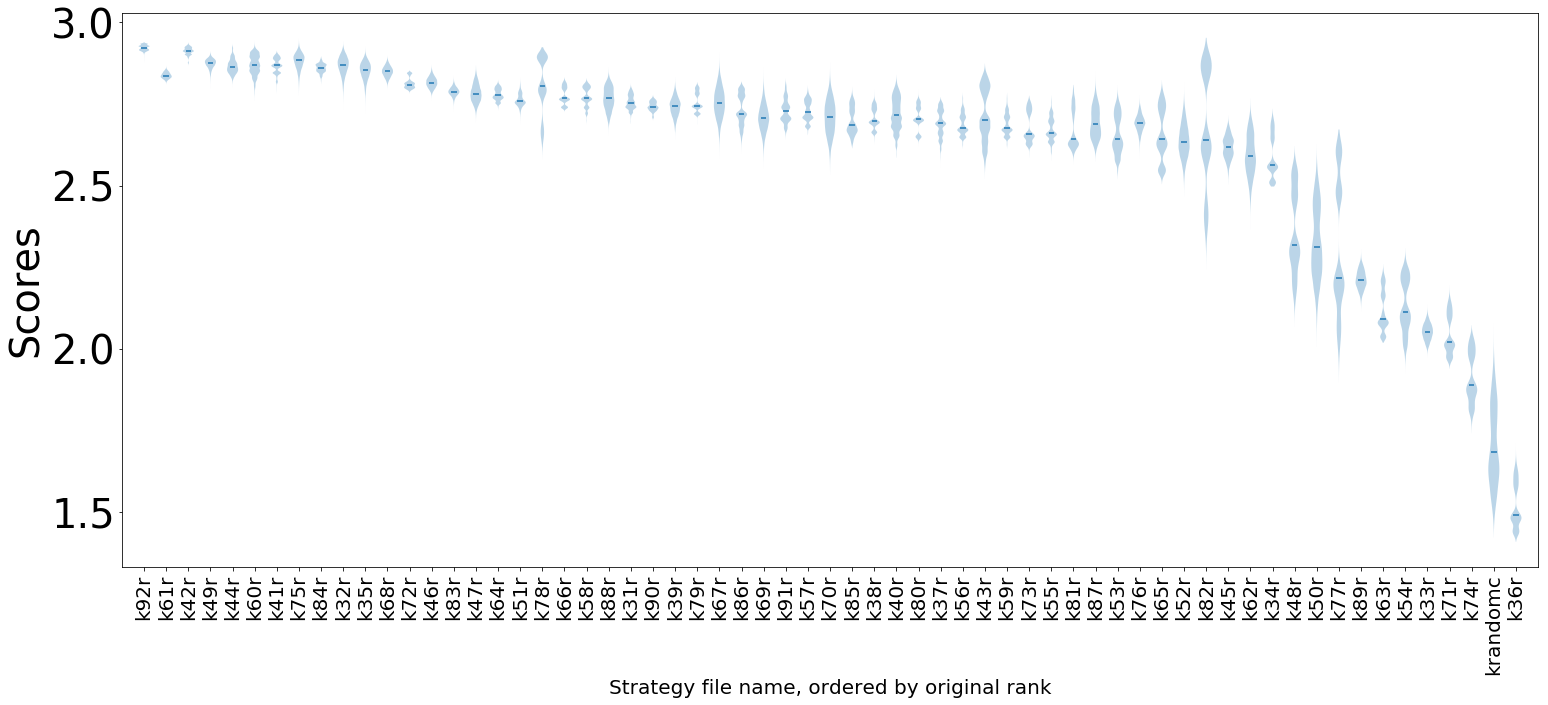

In [19]:
violon_plot(original_tournament_scores, original_score_summary, "../assets/original_scores_boxplots.pdf")
plt.ylabel("Scores", fontsize=40);

Let us consider the ranks over all repetitions of the tournaments (we have a lot of tournaments).

In [20]:
def summarise_ranks(scores):
    df = scores.rank(axis=1, ascending=False).describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean")
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    
    df["Author"] = [axlf.characteristics[name]["author"] for name in df.index]
    df["Original rank"] = [axlf.characteristics[name]["original_rank"] for name in df.index]
    
    return df

original_rank_summary = summarise_ranks(original_tournament_scores)

original_rank_summary.head(15)

,mean,std,min,5%,25%,50%,75%,95%,max,Author,Original rank
k92r,1.48828,0.760490,1,1.0,1.0,1.0,2.0,3.0,10,Anatol Rapoport,1
k42r,1.84832,0.735102,1,1.0,1.0,2.0,2.0,3.0,7,Otto Borufsen,3
k75r,5.38364,2.705719,1,2.0,3.0,5.0,7.0,11.0,17,Paul D Harrington,8
k49r,6.43042,2.479797,1,3.0,4.0,6.0,8.0,11.0,16,Rob Cave,4
k60r,6.90368,3.251751,1,3.0,4.0,6.0,9.0,13.0,18,Jim Graaskamp and Ken Katzen,6
k41r,7.35298,2.471817,2,4.0,6.0,7.0,9.0,12.0,16,Herb Weiner,7
k32r,7.36840,3.411956,1,3.0,4.0,7.0,10.0,13.0,27,Charles Kluepfel,10
k44r,7.83076,3.844811,1,2.5,4.0,8.0,11.0,14.0,18,William Adams,5
k84r,8.54422,2.211775,2,5.0,7.0,9.0,10.0,12.0,17,T Nicolaus Tideman and Paula Chieruzz,9
k35r,9.59490,3.321780,1,4.0,7.0,10.0,12.0,15.0,30,Abraham Getzler,11


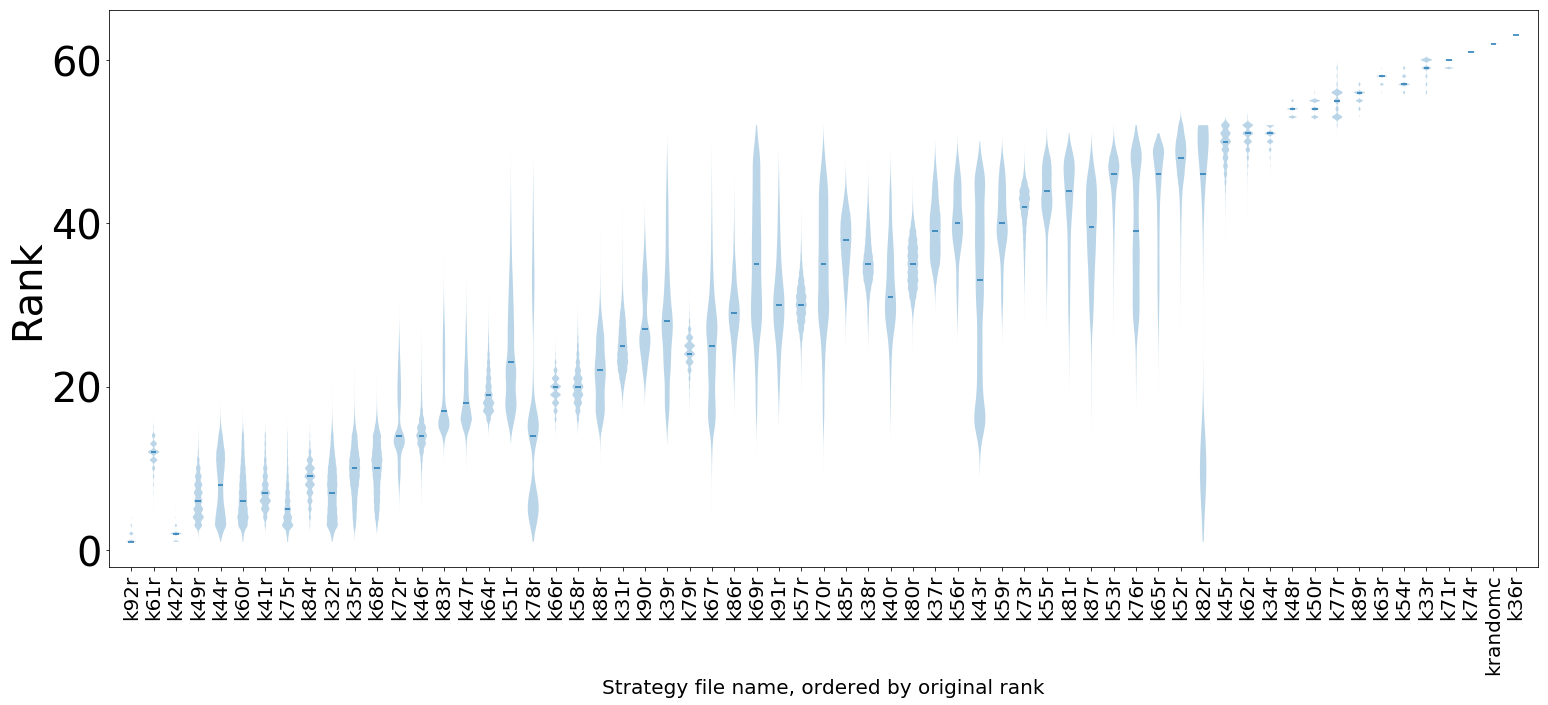

In [21]:
violon_plot(original_tournament_scores.rank(axis=1, ascending=False), 
            original_rank_summary, "../assets/original_ranks_boxplots.pdf")
plt.ylabel("Rank", fontsize=40);

Our scores (calculated above) ignore self interactions. Our payoffs do not:

In [47]:
def read_payoff_matrix(files, number_of_fortran_strategies=None):
    arrays = []
    turns = []
    repetitions = 0
    for gz_path in files:
        repetitions += get_repetitions(gz_path)
        arrays.append(np.array(pd.read_csv(str(gz_path), header=None)))  # Read through pd to deal with float conversion
        turns.append(get_turns(str(gz_path)))
    matrix = sum(array * turn for turn, array in zip(turns, arrays)) / sum(turns)
    
    if number_of_fortran_strategies is None:
        number_of_fortran_strategies = len(axlf.second_tournament_strategies)

    payoff_matrix = matrix[:-(number_of_fortran_strategies),:-(number_of_fortran_strategies)]

    self_interactions_matrix = matrix[-number_of_fortran_strategies:,:number_of_fortran_strategies] 
    padded_self_interactions_matrix = np.zeros(payoff_matrix.shape)
    padded_self_interactions_matrix[:self_interactions_matrix.shape[0],:self_interactions_matrix.shape[1]] = self_interactions_matrix
    payoff_matrix = padded_self_interactions_matrix + payoff_matrix
    return payoff_matrix, repetitions

In [48]:
original_tournament_payoff_matrix, original_repetitions = read_payoff_matrix(original_tournament_data_path.glob("*payoff_matrix.gz"))

In [49]:
scores = pd.DataFrame(original_tournament_payoff_matrix, 
                      axlf.second_tournament_strategies, 
                      columns=axlf.second_tournament_strategies)

In [50]:
scores["Scores"] = np.mean(original_tournament_payoff_matrix, axis=1)
scores["Rank"] = scores["Scores"].rank(ascending=False).astype(int)
scores["Original Rank"] =  [axlf.characteristics[name]["original_rank"] for name in scores.index]
scores["Author"] =  [axlf.characteristics[name]["author"] for name in scores.index]
scores.sort_values("Original Rank", inplace=True)

In [51]:
scores.head()

,k31r,k32r,k33r,k34r,k35r,k36r,k37r,k38r,k39r,k40r,...,k88r,k89r,k90r,k91r,k92r,krandomc,Scores,Rank,Original Rank,Author
k92r,3.0,3.0,2.900662,3.0,3.0,1.258567,3.0,3.0,2.993377,3.0,...,3.0,2.635762,3.0,3.0,3.0,2.245220,2.878558,1,1,Anatol Rapoport
k61r,3.0,3.0,2.854305,3.0,3.0,1.113196,3.0,3.0,2.993377,3.0,...,3.0,2.529972,3.0,3.0,3.0,1.878255,2.790761,12,2,Danny C Champion
k42r,3.0,3.0,2.137748,3.0,3.0,1.200127,3.0,3.0,2.993377,3.0,...,3.0,2.621192,3.0,3.0,3.0,2.794326,2.860705,2,3,Otto Borufsen
k49r,3.0,3.0,2.274614,3.0,3.0,1.283625,3.0,3.0,2.906950,3.0,...,3.0,2.366215,3.0,3.0,3.0,2.693678,2.825774,5,4,Rob Cave
k44r,3.0,3.0,2.361488,3.0,3.0,1.228111,3.0,3.0,2.794095,3.0,...,3.0,2.446296,3.0,3.0,3.0,2.201425,2.826085,3,5,William Adams


In [52]:
original_tournament_with_py_ch_data_path = pathlib.Path("./data/original_tournament_with_python_champion/")
original_tournament_with_py_ch_payoff_matrix, _ = read_payoff_matrix(original_tournament_with_py_ch_data_path.glob("*payoff_matrix.gz"),
                                                                     number_of_fortran_strategies=62)

In [53]:
player_names = [name for name in axlf.second_tournament_strategies if name != "k61r"] + ["k61r"]
len(player_names), original_tournament_with_py_ch_payoff_matrix.shape

(63, (63, 63))

In [54]:
py_ch_scores = pd.DataFrame(original_tournament_with_py_ch_payoff_matrix, 
                        player_names, 
                        columns=player_names)
py_ch_scores["Scores"] = np.mean(original_tournament_with_py_ch_payoff_matrix, axis=1)
py_ch_scores["Rank"] = py_ch_scores["Scores"].rank(ascending=False).astype(int)
py_ch_scores["Original Rank"] =  [axlf.characteristics[name]["original_rank"] for name in py_ch_scores.index]
py_ch_scores["Author"] =  [axlf.characteristics[name]["author"] for name in py_ch_scores.index]
py_ch_scores.sort_values("Original Rank", inplace=True)

Largest error in scores:

In [55]:
max(abs(py_ch_scores["Scores"] - scores["Scores"]))

0.0016164920963066542

In [56]:
fortran_strategies = [s for s in axlf.second_tournament_strategies 
                      if axlf.characteristics[s]["axelrod-python_class"] is None]
len(fortran_strategies)

43

In [57]:
fortran_strategies = [s for s in axlf.second_tournament_strategies 
                      if axlf.characteristics[s]["axelrod-python_class"] is None]
python_strategies = [s for s in axlf.second_tournament_strategies 
                     if axlf.characteristics[s]["axelrod-python_class"] is not None]

original_tournament_with_all_py_data_path = pathlib.Path("./data/original_tournament_with_python_implementations/")
original_tournament_with_all_py_payoff_matrix, _ = read_payoff_matrix(original_tournament_with_all_py_data_path .glob("*payoff_matrix.gz"),
                                                                      number_of_fortran_strategies=len(fortran_strategies))

In [58]:
player_names = fortran_strategies + python_strategies
py_scores = pd.DataFrame(original_tournament_with_all_py_payoff_matrix, 
                         player_names, 
                         columns=player_names)
py_scores["Scores"] = np.mean(original_tournament_with_all_py_payoff_matrix, axis=1)
py_scores["Rank"] = py_scores["Scores"].rank(ascending=False).astype(int)
py_scores["Original Rank"] =  [axlf.characteristics[name]["original_rank"] for name in py_scores.index]
py_scores["Author"] =  [axlf.characteristics[name]["author"] for name in py_scores.index]
py_scores.sort_values("Original Rank", inplace=True)

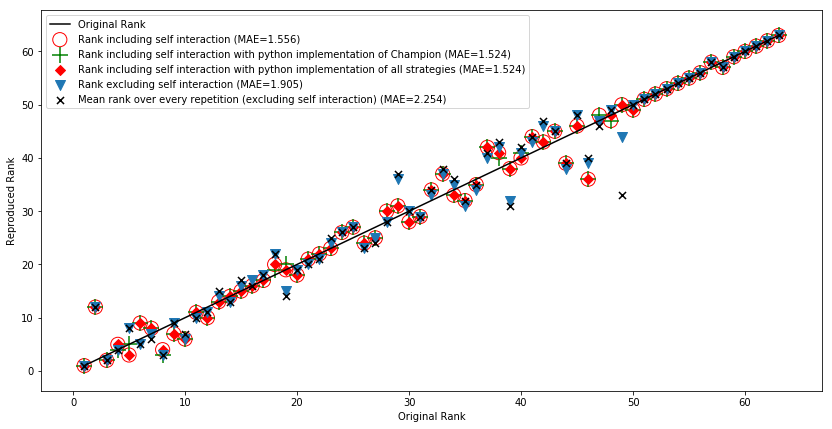

In [59]:
plt.subplots(1, figsize=(14, 7))

self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                      scores["Rank"])
self_interaction_py_ch_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                            py_ch_scores["Rank"])
self_interaction_py_all_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                              py_scores["Rank"])
excl_self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                           original_score_summary["mean"].rank(ascending=False))
mean_rank_mean_abs_error = mean_absolute_error(scores["Original Rank"],
                                               original_rank_summary["mean"].rank(ascending=True))
# TODO: Add more error calculations


plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], 
            label="Rank including self interaction (MAE={:.3f})".format(self_interaction_mean_abs_error),
            s=200,
            facecolors='none', edgecolors='r')
plt.scatter(py_scores["Original Rank"], py_ch_scores["Rank"], 
            label="Rank including self interaction with python implementation of Champion (MAE={:.3f})".format(self_interaction_py_ch_mean_abs_error),
            s=250,
            facecolors='g',
            marker="+")
plt.scatter(py_scores["Original Rank"], py_scores["Rank"], 
            label="Rank including self interaction with python implementation of all strategies (MAE={:.3f})".format(self_interaction_py_all_mean_abs_error),
            s=50,
            facecolors='r',
            marker="D")
plt.scatter(scores["Original Rank"], 
            original_score_summary["mean"].rank(ascending=False), 
            label="Rank excluding self interaction (MAE={:.3f})".format(excl_self_interaction_mean_abs_error), 
            s=100,
            marker="v",)
plt.scatter(scores["Original Rank"], original_rank_summary["mean"].rank(ascending=True), 
            label="Mean rank over every repetition (excluding self interaction) (MAE={:.3f})".format(mean_rank_mean_abs_error),
            s=50,
            marker="x",
            color="black")
plt.xlabel("Original Rank")
plt.ylabel("Reproduced Rank")
plt.legend()
plt.savefig("../assets/original_tournament_rankings_all_approaches.pdf");

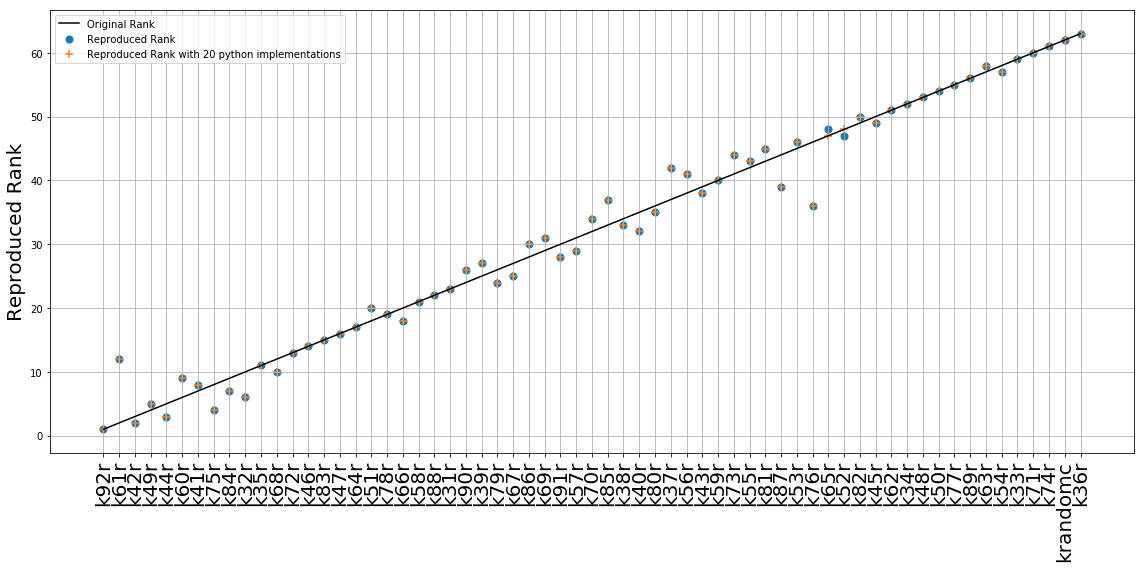

In [62]:
plt.subplots(1, figsize=(16, 8))

self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                      scores["Rank"])
excl_self_interaction_mean_abs_error = mean_absolute_error(scores["Original Rank"], 
                                                           original_score_summary["mean"].rank(ascending=False))
mean_rank_mean_abs_error = mean_absolute_error(scores["Original Rank"],
                                               original_rank_summary["mean"].rank(ascending=True))

plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], label="Reproduced Rank", s=50)
number_of_python_implementations = len(python_strategies)
plt.scatter(py_scores["Original Rank"], py_scores["Rank"], 
            label="Reproduced Rank with {} python implementations".format(number_of_python_implementations), 
            s=50, marker="+")

plt.xticks(range(1, len(scores.index) + 1), scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced Rank", fontsize=20)
plt.grid()
plt.legend()
plt.tight_layout()

Having examined the remaining outliers I do not see any immediate reason for the discrepancy.

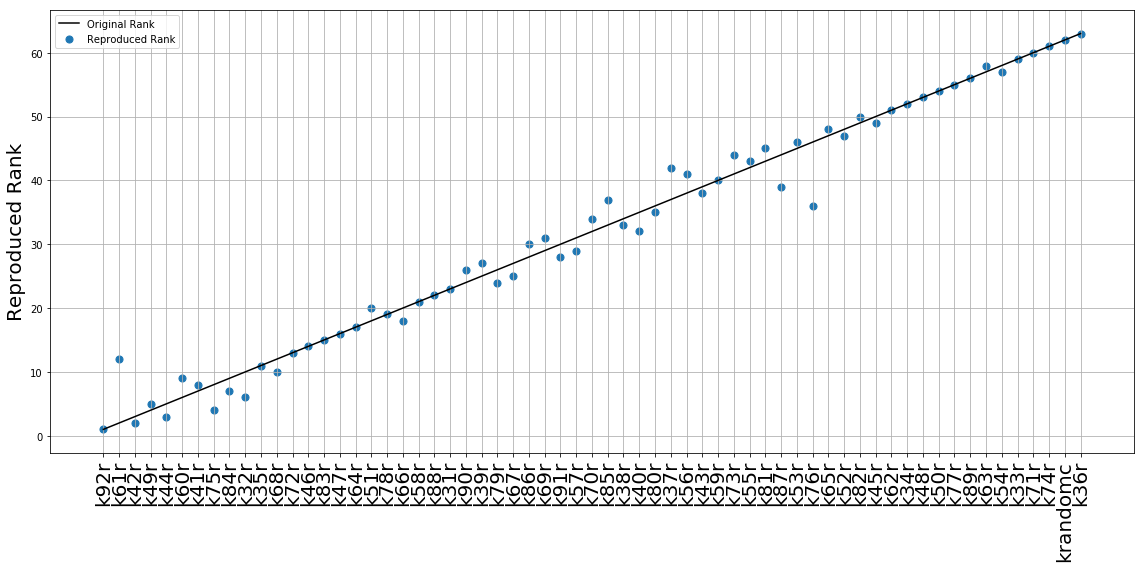

In [63]:
plt.subplots(1, figsize=(16, 8))



plt.plot(scores["Original Rank"], scores["Original Rank"], color="black")
plt.scatter(scores["Original Rank"], scores["Rank"], label="Reproduced Rank", s=50)
plt.xticks(range(1, len(scores.index) + 1), scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced Rank", fontsize=20)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../assets/original_tournament_rankings.pdf");

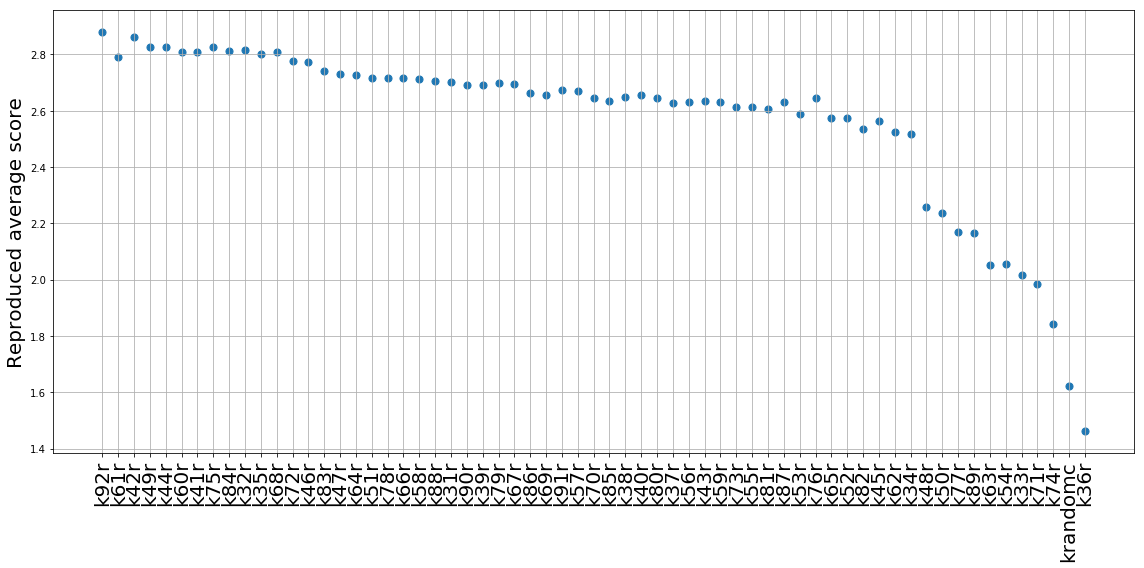

In [64]:
xs = range(len(scores.index))
plt.subplots(1, figsize=(16, 8))
plt.scatter(xs, scores["Scores"].values, s=50)
plt.xticks(xs, scores.index, rotation=90, fontsize=20)
plt.ylabel("Reproduced average score", fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig("../assets/original_tournament_scores.pdf");

In [46]:
ranking_df = scores[["Author", "Scores", "Rank", "Original Rank"]].round(4)
ranking_df.head(15)

,Author,Scores,Rank,Original Rank
k92r,Anatol Rapoport,2.8790,1,1
k61r,Danny C Champion,2.7907,12,2
k42r,Otto Borufsen,2.8608,2,3
k49r,Rob Cave,2.8261,3,4
k44r,William Adams,2.8259,5,5
k60r,Jim Graaskamp and Ken Katzen,2.8112,8,6
k41r,Herb Weiner,2.8098,10,7
k75r,Paul D Harrington,2.8259,4,8
k84r,T Nicolaus Tideman and Paula Chieruzz,2.8117,7,9
k32r,Charles Kluepfel,2.8197,6,10


In [47]:
with open("../assets/original_tournament_rankings.tex", "w") as f:
    f.write(ranking_df.head(15).to_latex())

Axelrod's original paper mentioned 5 strategies as representatives: https://github.com/Axelrod-Python/revisiting-axelrod-second/issues/3

Let us reproduce this.

In [48]:
r_squared_values = []
for i, _ in enumerate(axlf.second_tournament_strategies):
    number_of_strategies = i + 1
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=number_of_strategies)
    fit = rfe.fit(scores[axlf.second_tournament_strategies], scores["Scores"])
    model.fit(scores.iloc[:,fit.support_], scores["Scores"])
    scores["Predicted scores {} strategies".format(number_of_strategies)] = model.predict(scores.iloc[:,fit.support_])
    r_squared_values.append(r2_score(scores["Scores"], 
                                     scores["Predicted scores {} strategies".format(number_of_strategies)]))

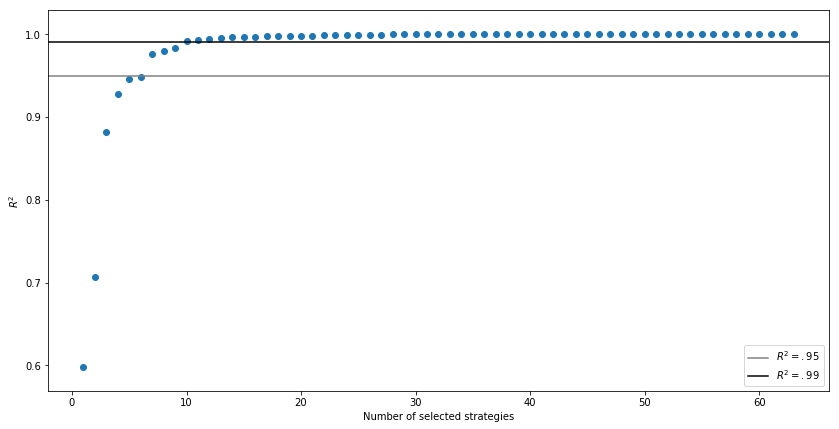

In [49]:
plt.subplots(1, figsize=(14, 7))

plt.scatter(range(1, len(axlf.second_tournament_strategies) + 1), r_squared_values)
plt.axhline(.95, label="$R^2=.95$", color="grey")
plt.axhline(.99, label="$R^2=.99$", color="black")
plt.xlabel("Number of selected strategies")
plt.ylabel("$R^2$")
plt.legend()
plt.savefig("../assets/original_tournament_r_squared_versus_number_of_features.pdf")

In [50]:
def write_linear_model_to_file(file_prefix, number_of_strategies=None, strategies=None):
    model = LinearRegression()
    Y =  scores["Scores"]
    
    if strategies is None:
        rfe = RFE(model, n_features_to_select=number_of_strategies)
        X = scores[axlf.second_tournament_strategies]
        fit = rfe.fit(X, Y)
        strategies = [name 
              for i, name in enumerate(axlf.second_tournament_strategies)
              if fit.support_[i]]      
        
    X = scores[strategies]
    model.fit(X, Y)
    

    coefficients = model.coef_
    intercept = model.intercept_
    
    F_values, p_values = f_regression(X, Y)
        
    
    with open("../assets/" + file_prefix + "_{}_model.tex".format(number_of_strategies).replace("None_", "",), "w") as f:
        f.write(pd.DataFrame({"Strategies": strategies + ["Intercept"], 
                              "Coefficients": list(coefficients) + [intercept], 
                              "$p$-value": list(p_values) + ["NA"],
                              "$F$-value": list(F_values) + ["NA"]}
                            )[["Strategies", "Coefficients", "$p$-value", "$F$-value"]].round(3).to_latex(index=False).replace("\\$", "$"))
    
    if number_of_strategies is not None:
        r_squared = r2_score(scores["Scores"], 
                             scores["Predicted scores {} strategies".format(number_of_strategies)])
    else:
        r_squared = r2_score(scores["Scores"], 
                             model.predict(X))
    with open("../assets/" + file_prefix + "_{}_r_squared.tex".format(number_of_strategies).replace("None_", "",), "w") as f:
        f.write("{:.4f}".format(r_squared))
        
    with open("data/training_strategies/" + file_prefix + "_{}_strategies.csv".format(number_of_strategies).replace("None_", "",), "w") as f:
        for player, weight in zip(strategies, coefficients):
            f.write("{},{}\n".format(player, weight))
        
    return model, r_squared

In [51]:
for number in [5, 17]:
    write_linear_model_to_file(file_prefix="original_tournament_predictive", 
                               number_of_strategies=number)

In [52]:
representative_strategies = ['k69r', 'k91r', 'k40r', 'k76r', 'k67r']
coefficients = [0.202, 0.198, 0.110, 0.072, 0.086]
intercept= 120 / 151
scores["Representative scores"] = intercept + sum(
                                            scores[strategy] * coefficient 
                                            for strategy, coefficient in zip(representative_strategies, 
                                                                             coefficients))


    
with open("../assets/original_tournament_representative_model.tex", "w") as f:
    f.write(pd.DataFrame({"Strategies": representative_strategies + ["Intercept"], 
                          "Coefficients": list(coefficients) + [intercept]}
                        )[["Strategies", "Coefficients"]].round(3).to_latex(index=False))
    
    
representative_r_squared = r2_score(scores["Scores"], scores["Representative scores"])
with open("../assets/original_tournament_representative_r_squared.tex", "w") as f:
    f.write("{:.4f}".format(representative_r_squared))
    
with open("data/training_strategies/original_tournament_representative_strategies.csv", "w") as f:
    for player, weight in zip(representative_strategies, coefficients):
        f.write("{},{}\n".format(player, weight))

In [53]:
linear_model_with_original_5, linear_model_with_original_5_r_squared  = write_linear_model_to_file(
                           file_prefix="original_tournament_predictive_with_axelrod_5", 
                           strategies=representative_strategies)

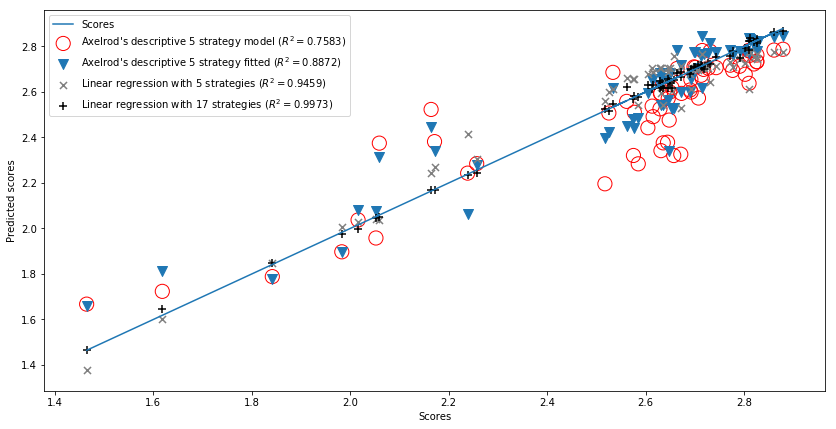

In [54]:
plt.subplots(1, figsize=(14, 7))

plt.plot(scores["Scores"], scores["Scores"])
plt.scatter(scores["Scores"], scores["Representative scores"], 
            label="Axelrod's descriptive 5 strategy model ($R^2={:.4f}$)".format(representative_r_squared),
            s=200,
            facecolors='none', edgecolors='r')

plt.scatter(scores["Scores"], linear_model_with_original_5.predict(scores[representative_strategies]), 
            label="Axelrod's descriptive 5 strategy fitted ($R^2={:.4f}$)".format(linear_model_with_original_5_r_squared),
            s=100,
            marker="v",)
plt.scatter(scores["Scores"], scores["Predicted scores 5 strategies"], 
            label="Linear regression with 5 strategies ($R^2={:.4f}$)".format(r_squared_values[4]),
            s=50,
            marker="x",
            color="grey")
plt.scatter(scores["Scores"], scores["Predicted scores 17 strategies"], 
            label="Linear regression with 17 strategies ($R^2={:.4f}$)".format(r_squared_values[16]),
            s=50,
            marker="+",
            color="black")

plt.legend()
plt.xlabel("Scores")
plt.ylabel("Predicted scores")
plt.savefig("../assets/original_tournament_predictive_score_models.pdf");

# What was the tournament "like"

Let us take a look at summary statistics and cooperation rates.

In [55]:
original_tournament_cooperation_rates = read_payoff_matrix(original_tournament_data_path.glob("*cooperation_rates.gz"))[0].transpose()

In [56]:
with open("../assets/original_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(original_tournament_cooperation_rates)))
np.mean(original_tournament_cooperation_rates)

0.75039740312154646

In [57]:
cooperation_rates = pd.DataFrame(original_tournament_cooperation_rates, 
                                axlf.second_tournament_strategies, 
                                columns=axlf.second_tournament_strategies)

In [58]:
# Columns are opponents
# Rows are players
cooperation_rates = cooperation_rates.merge(scores[["Rank"]], left_index=True, right_index=True)
cooperation_rates["Mean cooperation rate"] = np.mean(original_tournament_cooperation_rates, axis=1)
cooperation_rates.sort_values("Rank", inplace=True)

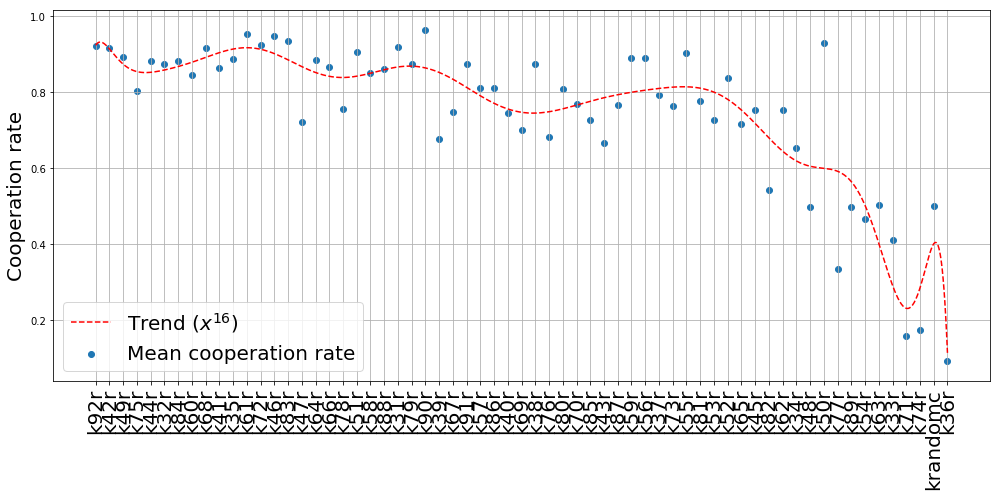

In [59]:
plt.subplots(1, figsize=(14, 7))

plt.scatter(cooperation_rates["Rank"], cooperation_rates["Mean cooperation rate"])

degree = 16
z = np.polyfit(cooperation_rates["Rank"], cooperation_rates["Mean cooperation rate"], degree)
p = np.poly1d(z)
x = np.linspace(1, cooperation_rates["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend ($x^{{{}}}$)".format(degree))

plt.ylabel("Cooperation rate", fontsize=20)
plt.xticks(range(1, len(cooperation_rates) + 1), cooperation_rates.index, rotation=90, fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig("../assets/original_tournament_cooperation_rate_versus_rank.pdf")

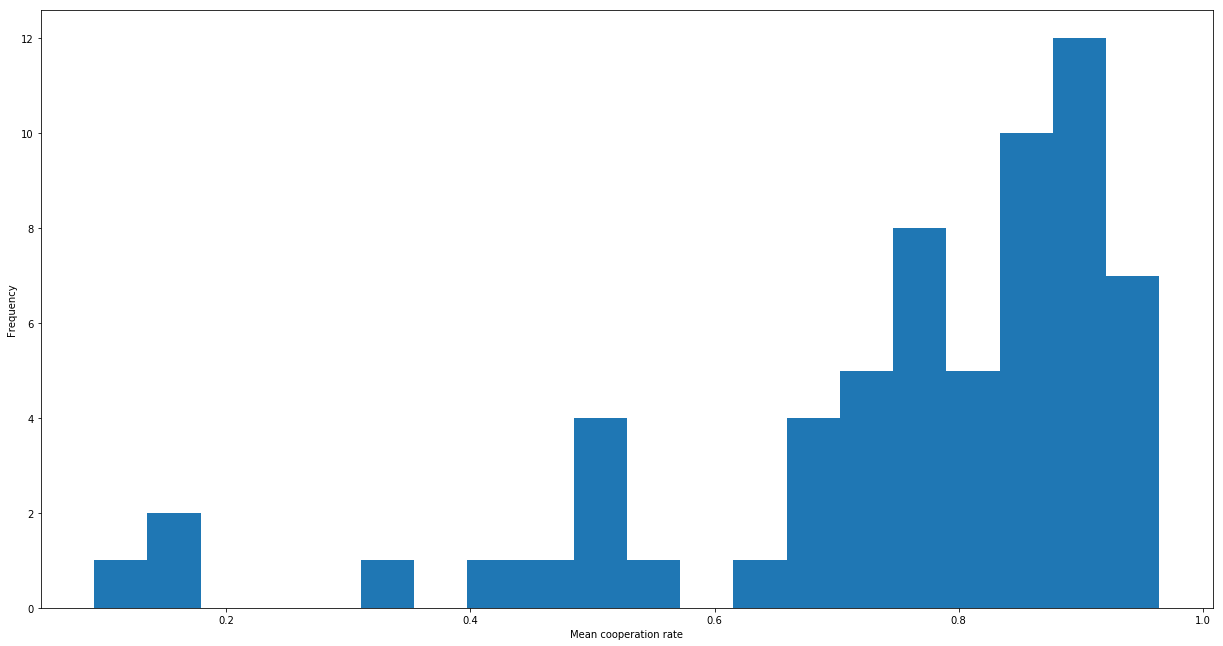

In [60]:
plt.subplots(1, figsize=(21, 11))

plt.hist(cooperation_rates["Mean cooperation rate"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/original_tournament_cooperation_rates.pdf")

In [61]:
def matrix_heatmap(matrix, player_names, filename):
    number_of_players = len(player_names)
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_xticks(range(number_of_players))
    ax.set_yticks(range(number_of_players))
    ax.set_xticklabels(player_names, rotation=90)
    ax.set_yticklabels(player_names)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cax.tick_params(labelsize=40) 
    fig.colorbar(mat, cax=cax)

    fig.tight_layout()
    fig.savefig(filename);

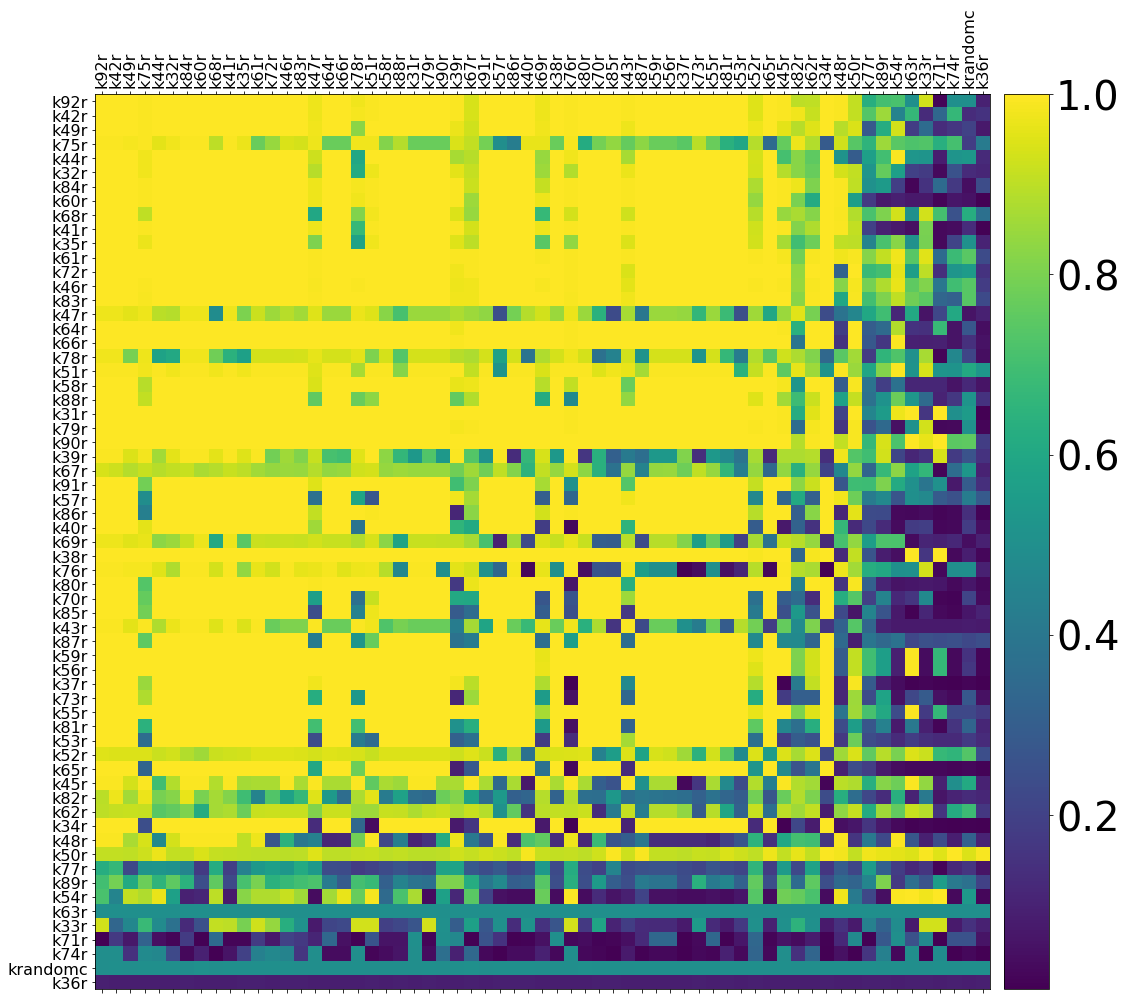

In [62]:
matrix_heatmap(cooperation_rates[cooperation_rates.index], cooperation_rates.index, 
               "../assets/original_tournament_pairwise_cooperation_rates.pdf")

## Adding another strategy from the library

In [43]:
library_summary = pd.read_csv("data/std_summary_v_3.8.1.csv", index_col="Name")
library_summary["Rank"] += 1

In [58]:
original_tournament_with_extra_data_path = pathlib.Path("./data/original_tournament_with_extra_strategy/")

In [59]:
data = {"Name": [], 
        "Repetitions": [], 
        "Rank": [],
        "Library Rank": [],
        "Cooperation Rate against opponents": [],
        "Cooperation Rate from opponents": [],
        "Score": [],
        "Winner": [],
        "Winner score": []}
for index, strategy in enumerate(axl.strategies):
    player = strategy()
    name = player.name
    if name not in ["Alexei", "Contrite Tit For Tat"]:  # Removing these as they correspond to TfT in these conditions

        representation = str(player)
        pattern = "*player_{}*{}*payoff_matrix.gz".format(index, name)
        files = list(original_tournament_with_extra_data_path.glob(pattern))
        if len(files) > 0:
            payoff_matrix, repetitions = read_payoff_matrix(files)
            mean_scores = np.mean(payoff_matrix, axis=1)


            pattern = "*{}*cooperation_rates.gz".format(name)
            files = list(original_tournament_with_extra_data_path.glob(pattern))
            cooperation_matrix = read_payoff_matrix(files)[0].transpose()
            player_against_opponents_cooperation_rate = np.mean(cooperation_matrix, axis=1)[-1]
            opponents_against_player_cooperation_rate = np.mean(cooperation_matrix, axis=0)[-1]

            player_score = mean_scores[-1]
            player_rank = sorted(mean_scores, reverse=True).index(player_score) + 1
            try:
                winner = axlf.second_tournament_strategies[np.argmax(mean_scores)]
            except IndexError:
                winner = name

            data["Name"].append(name)
            data["Repetitions"].append(repetitions)
            data["Rank"].append(player_rank)
            data["Score"].append(player_score)
            data["Library Rank"].append(library_summary["Rank"][representation])
            data["Cooperation Rate against opponents"].append(player_against_opponents_cooperation_rate)
            data["Cooperation Rate from opponents"].append(opponents_against_player_cooperation_rate)
            data["Winner"].append(winner)
            data["Winner score"].append(np.max(mean_scores))
        
extra_strategy_df = pd.DataFrame(data).set_index("Name").sort_values(["Rank", "Score"])

In [60]:
extra_strategy_repetitions = extra_strategy_df["Repetitions"].min()
with open("../assets/number_of_extra_strategy_repetitions.tex", "w") as f:
    f.write(str(extra_strategy_repetitions))
extra_strategy_repetitions

5750

In [61]:
with open("../assets/original_tournament_with_extra_strategy_summary.tex", "w") as f:
    columns = ["Cooperation Rate against opponents", "Cooperation Rate from opponents", "Library Rank", "Rank", "Score", "Winner"]
    f.write(extra_strategy_df.head(20)[columns].round(3).to_latex().replace("\_", "\\_"))
extra_strategy_df

,Cooperation Rate against opponents,Cooperation Rate from opponents,Library Rank,Rank,Repetitions,Score,Winner,Winner score
Name,,,,,,,,
Omega TFT,0.887909,0.903994,14,2,8250,2.853735,k92r,2.880214
EvolvedLookerUp2_2_2,0.839459,0.841887,1,15,12500,2.764609,k92r,2.880551
Evolved HMM 5,0.830721,0.835405,2,17,12500,2.727967,k92r,2.880624
Evolved FSM 16 Noise 05,0.818761,0.831561,5,22,12500,2.714696,k92r,2.880435
Winner12,0.754325,0.790440,13,23,8250,2.705421,k92r,2.880213
PSO Gambler Mem1,0.815477,0.824534,9,24,9500,2.704682,k92r,2.880202
Evolved FSM 16,0.811610,0.817384,4,26,12500,2.692058,k92r,2.880476
Evolved ANN 5,0.823830,0.826783,7,27,12500,2.682524,k92r,2.880451
Evolved ANN,0.816746,0.823843,6,27,12500,2.685100,k92r,2.880565


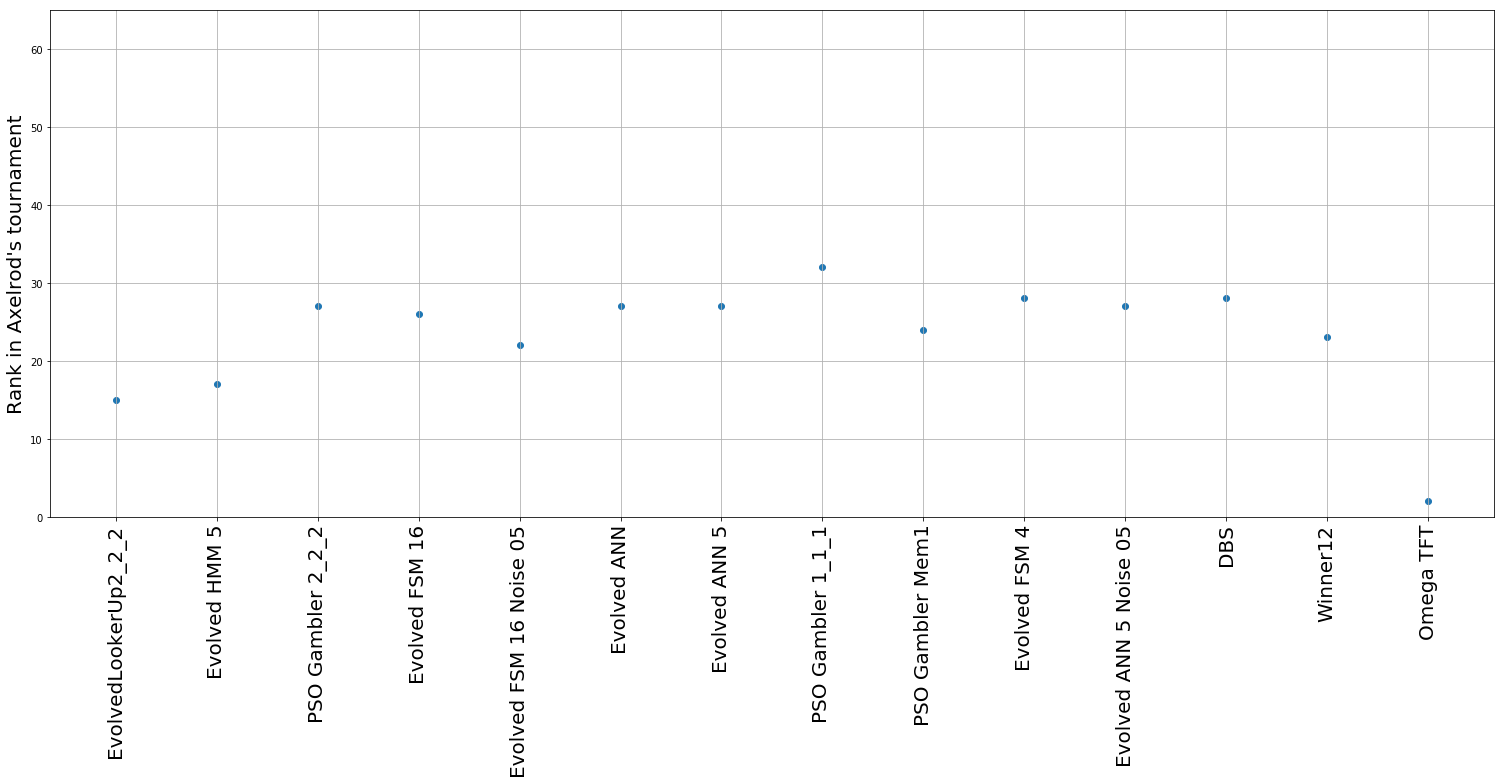

In [62]:
plt.subplots(1, figsize=(21, 11))


extra_strategy_df.sort_values("Library Rank", inplace=True)
plt.scatter(extra_strategy_df["Library Rank"], extra_strategy_df["Rank"])
plt.ylabel("Rank in Axelrod's tournament", fontsize=20)
plt.xticks(extra_strategy_df["Library Rank"], 
           extra_strategy_df.sort_values("Library Rank").index, rotation=90, fontsize=20)
plt.ylim(0, len(axlf.second_tournament_strategies) + 2)
plt.grid()
plt.tight_layout();
plt.savefig("../assets/original_tournament_with_extra_strategy_ranks_vs_library_ranks.pdf");

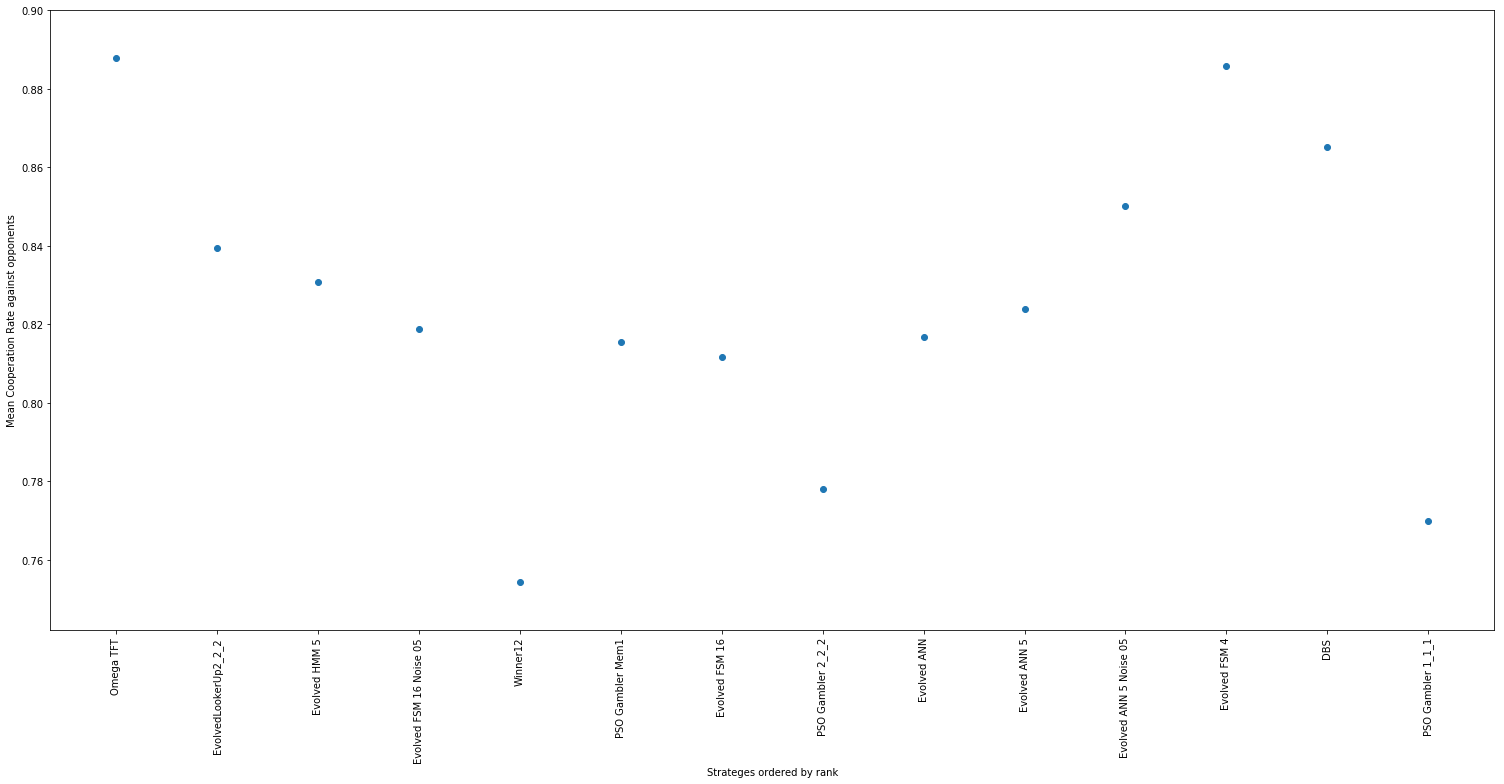

In [63]:
plt.subplots(1, figsize=(21, 11))

extra_strategy_df.sort_values("Rank", inplace=True)

plt.scatter(range(1, len(extra_strategy_df.index) + 1), extra_strategy_df["Cooperation Rate against opponents"])
plt.xlabel("Strateges ordered by rank")
plt.ylabel("Mean Cooperation Rate against opponents")
plt.xticks(range(1, len(extra_strategy_df.index) + 1), 
           extra_strategy_df.index, rotation=90)
plt.tight_layout();
plt.savefig("../assets/original_tournament_with_extra_strategy_cooperation_rates_vs_opponents.pdf");

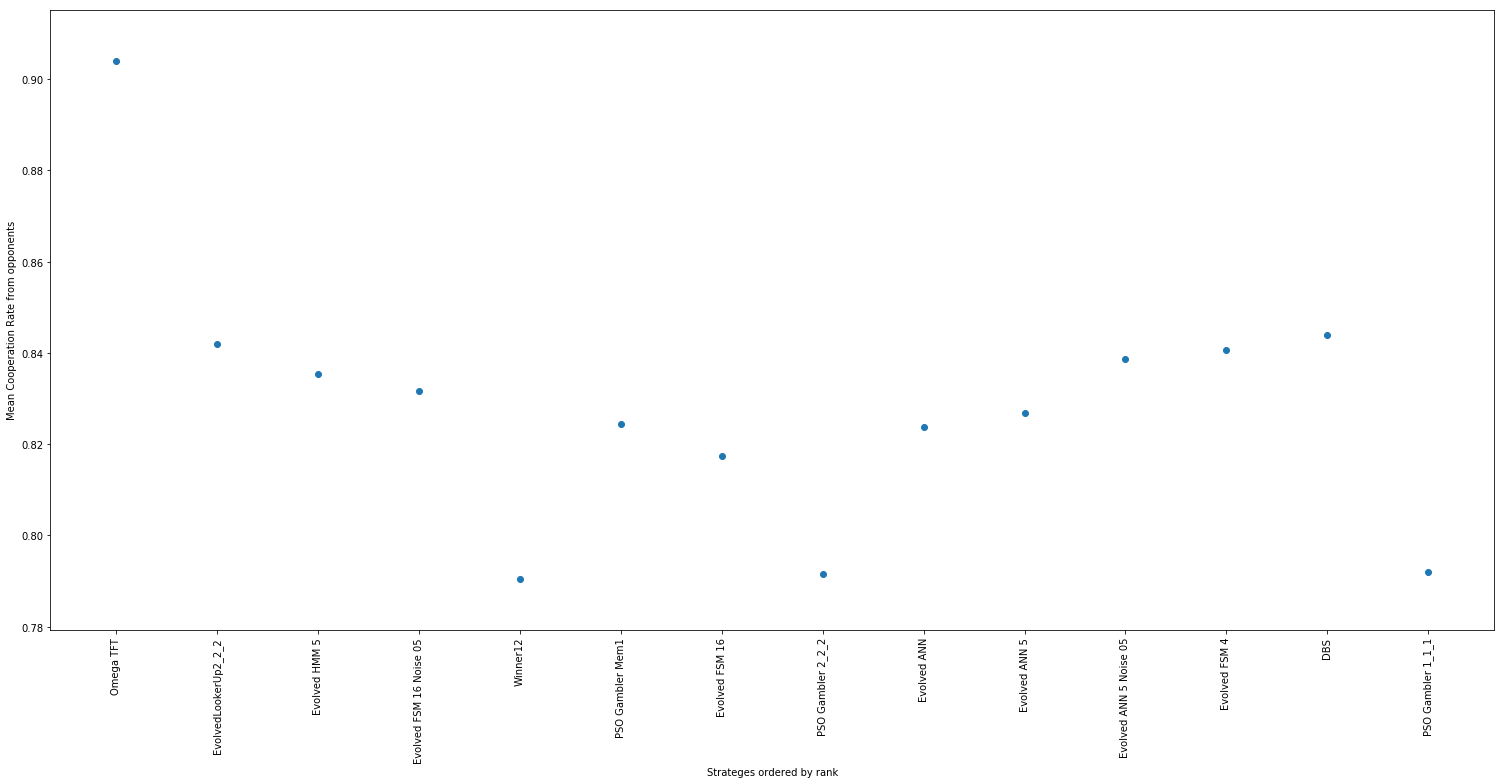

In [64]:
plt.subplots(1, figsize=(21, 11))

plt.scatter(range(1, len(extra_strategy_df.index) + 1), extra_strategy_df["Cooperation Rate from opponents"])
plt.xlabel("Strateges ordered by rank")
plt.ylabel("Mean Cooperation Rate from opponents")
plt.xticks(range(1, len(extra_strategy_df.index) + 1), 
           extra_strategy_df.index, rotation=90)
plt.tight_layout();
plt.savefig("../assets/original_tournament_with_extra_strategy_cooperation_rates_from_opponents.pdf");

## Training strategies

We can train strategies using the sets and weight obtained using the linear regression.

In [ ]:
train_all = pd.read_csv("data/training_strategies/training_data_original_tournament_full_players.csv", 
                        header=None, 
                        names=["gen", "Mean", "Std", "Max", "Best"],)
                        #index_col="index")
train_full = pd.read_csv("data/training_strategies/training_data_original_tournament_full_players_with_axl.csv", 
                         header=None, 
                         names=["gen", "Mean", "Std", "Max", "Best"],)
                         #index_col="index")
train_pred_12 = pd.read_csv("data/training_strategies/training_data_original_tournament_predictive_12_strategies.csv", 
                        header=None, 
                        names=["gen", "Mean", "Std", "Max", "Best"],)
                        #index_col="index")
train_pred_5 = pd.read_csv("data/training_strategies/training_data_original_tournament_predictive_5_strategies.csv", 
                        header=None, 
                        names=["gen", "Mean", "Std", "Max", "Best"],)
                        #index_col="index")
train_pred_axl_5 = pd.read_csv("data/training_strategies/training_data_original_tournament_predictive_with_axelrod_5_strategies.csv",
                        header=None, 
                        names=["gen", "Mean", "Std", "Max", "Best"],)
                        #index_col="index")
train_rep = pd.read_csv("data/training_strategies/training_data_original_tournament_representative_strategies.csv", 
                        header=None, 
                        names=["gen", "Mean", "Std", "Max", "Best"],)
                        #index_col="index")

In [ ]:
len(train_rep.index), len(train_full.index)

In [ ]:
plt.subplots(1, figsize=(14, 7))
plt.plot(train_all["Max"], 
         label="Train against all ({} generations)".format(len(train_all.index)))
plt.plot(train_full["Max"], 
         label="Train against all and axl ({} generations)".format(len(train_full.index)))
plt.plot(train_pred_12["Max"], 
         label="Train against predictive 12 ({} generations)".format(len(train_pred_12.index)))
plt.plot(train_pred_5["Max"], 
         label="Train against predictive 5 ({} generations)".format(len(train_pred_5.index)))
plt.plot(train_pred_axl_5["Max"], 
         label="Train against predictive Axelrod 5 ({} generations)".format(len(train_pred_axl_5.index)))
plt.plot(train_rep["Max"], 
         label="Train against Axelrod 5 ({} generations)".format(len(train_rep.index)))
plt.legend()
plt.savefig("../assets/training_data_max_score.pdf")

# TODO Improve this plot for potential for B&W

In [ ]:
original_tournament_trained_strategies = pathlib.Path("./data/training_strategies/")

In [ ]:
data = {"Training environment": [], 
        "Repetitions": [], 
        "Rank": [],
        "Cooperation Rate against opponents": [],
        "Cooperation Rate from opponents": [],
        "Score": [],
        "Winner": []}
for training_env in ["full_players_with_axl",
                     "full_players", 
                     "predictive_12_strategies",
                     "predictive_5_strategies",
                     "predictive_with_axelrod_5_strategies",
                     "representative_strategies"]:

    

    pattern = "*{}*payoff_matrix.gz".format(training_env)
    files = list(original_tournament_trained_strategies.glob(pattern))
    if len(files) > 0:
        if training_env == "full_players":
            files = [f for f in files if "with_axl" not in str(f)]
        payoff_matrix, repetitions = read_payoff_matrix(files)
        mean_scores = np.mean(payoff_matrix, axis=1)

        
        pattern = "*{}*cooperation_rates.gz".format(training_env)
        files = list(original_tournament_trained_strategies.glob(pattern))
        cooperation_matrix = read_payoff_matrix(files)[0].transpose()
        player_against_opponents_cooperation_rate = np.mean(cooperation_matrix, axis=1)[-1]
        opponents_against_player_cooperation_rate = np.mean(cooperation_matrix, axis=0)[-1]
        
        player_score = mean_scores[-1]
        player_rank = sorted(mean_scores, reverse=True).index(player_score) + 1
        try:
            winner = axlf.second_tournament_strategies[np.argmax(mean_scores)]
        except IndexError:
            winner = "Trained strategy"
        
        data["Training environment"].append(training_env.title())
        data["Repetitions"].append(repetitions)
        data["Score"].append(player_score)
        data["Rank"].append(player_rank)
        data["Cooperation Rate against opponents"].append(player_against_opponents_cooperation_rate)
        data["Cooperation Rate from opponents"].append(opponents_against_player_cooperation_rate)
        data["Winner"].append(winner)
        
training_environments_df = pd.DataFrame(data).set_index("Training environment").sort_values("Rank")

In [ ]:
with open("../assets/original_tournament_with_trained_strategy.tex", "w") as f:
    columns = ["Cooperation Rate against opponents", "Cooperation Rate from opponents", 
               "Rank", "Score", "Winner"]
    f.write(training_environments_df.head(20)[columns].round(3).to_latex().replace("\_", " "))
training_environments_df

## Investigating the S&P strategies

In [30]:
from run_sp_tournament import players as sp_players

sp_player_names = []
for p in sp_players:
    try:
        sp_player_names.append(p.original_name)
    except AttributeError:
        sp_player_names.append(p.name)

In [66]:
sp_tournament_data_path = pathlib.Path("./data/sp_tournament/")
sp_tournament_payoff_matrix, sp_repetitions = read_payoff_matrix(sp_tournament_data_path.glob("*payoff_matrix.gz"))

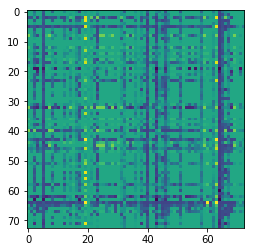

In [67]:
plt.imshow(sp_tournament_payoff_matrix)

In [ ]:
with open("../assets/number_of_sp_repetitions.tex", "w") as f:
    f.write(str(sp_repetitions))

sp_repetitions

In [ ]:
assert sp_tournament_payoff_matrix.shape == (len(sp_players), len(sp_players))

In [ ]:
sp_scores = pd.DataFrame(sp_tournament_payoff_matrix, 
                         sp_player_names, 
                         sp_player_names)

In [ ]:
dummy_dict = {"original_rank": -1, "author": "NA"}
sp_scores["Scores"] = np.mean(sp_tournament_payoff_matrix, axis=1)
sp_scores["Rank"] = sp_scores["Scores"].rank(ascending=False).astype(int)
sp_scores["Original Rank"] =  [axlf.characteristics.get(name, dummy_dict)["original_rank"] 
                               for name in sp_scores.index]

sp_scores["Original Author"] =  [axlf.characteristics.get(name, dummy_dict)["author"] 
                        for name in sp_scores.index]

sp_scores = sp_scores.merge(scores[["Rank"]].rename(columns={"Rank": "Reproduced Rank"}), left_index=True, right_index=True, how="left")
sp_scores.fillna('-1', inplace=True)
sp_scores.sort_values("Rank", inplace=True)

In [ ]:
sp_scores.head()

In [ ]:
sp_ranking_df = sp_scores[["Original Author", "Scores", "Rank", "Original Rank", "Reproduced Rank"]].round(4)
sp_ranking_df.head(15)

In [ ]:
with open("../assets/sp_tournament_rankings.tex", "w") as f:
    f.write(sp_ranking_df.head(15).to_latex().replace("-1", "NA"))

In [ ]:
sp_tournament_cooperation_rates = read_payoff_matrix(sp_tournament_data_path.glob("*cooperation_rates.gz"))[0].transpose()

In [ ]:
with open("../assets/sp_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(sp_tournament_cooperation_rates)))
np.mean(sp_tournament_cooperation_rates)

In [ ]:
sp_cooperation_rates = pd.DataFrame(sp_tournament_cooperation_rates, 
                                    sp_player_names, 
                                    columns=sp_player_names)

In [ ]:
sp_cooperation_rates = sp_cooperation_rates.merge(sp_scores[["Rank"]], left_index=True, right_index=True)
sp_cooperation_rates["Mean cooperation rate"] = np.mean(sp_tournament_cooperation_rates, axis=1)
sp_cooperation_rates.sort_values("Rank", inplace=True)

In [ ]:
plt.subplots(1, figsize=(14, 7))

plt.scatter(sp_cooperation_rates["Rank"], sp_cooperation_rates["Mean cooperation rate"])

z = np.polyfit(sp_cooperation_rates["Rank"], sp_cooperation_rates["Mean cooperation rate"], 16)
p = np.poly1d(z)
x = np.linspace(1, sp_cooperation_rates["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend")


plt.xlabel("Strateges ordered by rank")
plt.ylabel("Cooperation rate")
plt.xticks(range(1, len(sp_cooperation_rates) + 1), sp_cooperation_rates.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("../assets/sp_tournament_cooperation_rate_versus_rank.pdf")

In [ ]:
plt.subplots(1, figsize=(21, 11))

plt.hist(sp_cooperation_rates["Mean cooperation rate"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/sp_tournament_cooperation_rates.pdf")

In [ ]:
matrix_heatmap(sp_cooperation_rates[sp_cooperation_rates.index], sp_cooperation_rates.index, 
               "../assets/sp_tournament_pairwise_cooperation_rates.pdf")

## Investigating the full tournament.

In [ ]:
from run_full_tournament import players as full_players

full_player_names = []
for p in full_players:
    try:
        full_player_names.append(p.original_name)
    except AttributeError:
        full_player_names.append(p.name)
        
library_names_to_repr = {s.name: s().__repr__() for s in axl.strategies}
assert len(full_player_names) == 257

In [ ]:
with open("../assets/library_tournament_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(library_summary["Cooperation_rating"])))
np.mean(library_summary["Cooperation_rating"])

In [ ]:
plt.subplots(1, figsize=(21, 11))

plt.hist(library_summary["Cooperation_rating"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/library_tournament_cooperation_rates.pdf")

In [ ]:
full_tournament_data_path = pathlib.Path("./data/full_tournament/")
full_tournament_payoff_matrix, full_repetitions = read_payoff_matrix(full_tournament_data_path.glob("*payoff_matrix.gz"))

In [ ]:
with open("../assets/number_of_full_repetitions.tex", "w") as f:
    f.write(str(full_repetitions))
full_repetitions

In [ ]:
assert full_tournament_payoff_matrix.shape == (len(full_players), len(full_players))

In [ ]:
full_scores = pd.DataFrame(full_tournament_payoff_matrix, 
                           full_player_names, 
                           full_player_names)

In [ ]:
dummy_dict = {"original_rank": -1, "author": "NA"}
full_scores["Scores"] = np.mean(full_tournament_payoff_matrix, axis=1)
full_scores["Rank"] = full_scores["Scores"].rank(ascending=False).astype(int)
full_scores["Original Rank"] =  [axlf.characteristics.get(name, dummy_dict)["original_rank"] 
                               for name in full_scores.index]
full_scores["Library Rank"] =  [library_summary["Rank"].get(library_names_to_repr.get(name, "No rank"), -1) 
                                 for name in full_scores.index]

full_scores["Original Author"] =  [axlf.characteristics.get(name, dummy_dict)["author"] 
                        for name in full_scores.index]

full_scores = full_scores.merge(scores[["Rank"]].rename(columns={"Rank": "Reproduced Rank"}), left_index=True, right_index=True, how="left")
full_scores.fillna('-1', inplace=True)
full_scores.sort_values("Rank", inplace=True)

In [ ]:
full_scores.head()

In [ ]:
full_ranking_df = full_scores[["Original Author", "Scores", "Rank", "Library Rank",  "Original Rank","Reproduced Rank"]].round(4)
full_ranking_df.head(20)

In [ ]:
with open("../assets/full_tournament_rankings.tex", "w") as f:
    f.write(full_ranking_df.head(20).to_latex().replace("-1", "NA").replace("\_", "\\_"))

In [ ]:
full_tournament_cooperation_rates = read_payoff_matrix(full_tournament_data_path.glob("*cooperation_rates.gz"))[0].transpose()

In [ ]:
with open("../assets/full_tournament_overall_cooperation_rate.tex", "w") as f:
    f.write("{:.03f}".format(np.mean(full_tournament_cooperation_rates)))
np.mean(full_tournament_cooperation_rates)

In [ ]:
full_cooperation_rates = pd.DataFrame(full_tournament_cooperation_rates, 
                                      full_player_names, 
                                      columns=full_player_names)

In [ ]:
full_cooperation_rates = full_cooperation_rates.merge(full_scores[["Rank"]], left_index=True, right_index=True)
full_cooperation_rates["Mean cooperation rate"] = np.mean(full_tournament_cooperation_rates, axis=1)
full_cooperation_rates.sort_values("Rank", inplace=True)

In [ ]:
plt.subplots(1, figsize=(21, 11))

plt.scatter(full_cooperation_rates["Rank"], full_cooperation_rates["Mean cooperation rate"])

z = np.polyfit(full_cooperation_rates["Rank"], full_cooperation_rates["Mean cooperation rate"], 16)
p = np.poly1d(z)
x = np.linspace(1, full_cooperation_rates["Rank"].max(), 1000)
plt.plot(x,p(x),"r--", label="Trend")

plt.xlabel("Strateges ordered by rank")
plt.ylabel("Cooperation rate")
plt.xticks(range(1, len(full_cooperation_rates) + 1), full_cooperation_rates.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("../assets/full_tournament_cooperation_rate_versus_rank.pdf")

In [ ]:
plt.subplots(1, figsize=(21, 11))

plt.hist(full_cooperation_rates["Mean cooperation rate"], bins=20)
plt.xlabel("Mean cooperation rate")
plt.ylabel("Frequency")
plt.savefig("../assets/full_tournament_cooperation_rates.pdf")

In [ ]:
matrix_heatmap(full_cooperation_rates[full_cooperation_rates.index], full_cooperation_rates.index, 
               "../assets/full_tournament_pairwise_cooperation_rates.pdf")